<a href="https://colab.research.google.com/github/Saivam/23-5-23/blob/main/dtw_gee_connected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install dtaidistance

In [ ]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dtaidistance import dtw

In [ ]:
ee.Authenticate()

True

In [ ]:
ee.Initialize(project='tough-cipher-408608')

# Step 3: Define AOI - Ongole in Prakasam District
aoi = ee.Geometry.Rectangle([79.9792, 15.4697, 80.0792, 15.5697])

In [ ]:
def get_ndvi_time_series(aoi, start_date, end_date):
    collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDVI')\
                    .filterDate(start_date, end_date)\
                    .filterBounds(aoi)

    def extract_ndvi(image):
        mean_ndvi = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=30).get('NDVI')
        return ee.Feature(None, {'mean_ndvi': mean_ndvi, 'date': image.date().format()})

    # Get features info
    ndvi_features = collection.map(extract_ndvi).getInfo()['features']

    # Filter features to ensure both 'mean_ndvi' and 'date' are present
    filtered_features = [f for f in ndvi_features if 'mean_ndvi' in f['properties'] and f['properties']['mean_ndvi'] is not None and 'date' in f['properties']]

    # Extract 'mean_ndvi' and 'date' from filtered features
    ndvi_values = [feature['properties']['mean_ndvi'] for feature in filtered_features]
    dates = [pd.to_datetime(feature['properties']['date']) for feature in filtered_features]

    return dates, ndvi_values

In [ ]:
start_date = '2019-01-01'
end_date = '2022-01-31'
dates, ndvi_values = get_ndvi_time_series(aoi, start_date, end_date)

In [ ]:
def apply_twdtw(series1, series2, time_weight=0.5):
    series1 = np.array(series1) / np.max(series1)
    series2 = np.array(series2) / np.max(series2)
    time_component = np.linspace(0, time_weight, len(series1))
    series1_weighted = series1 + time_component
    series2_weighted = series2 + time_component
    distance = dtw.distance(series1_weighted, series2_weighted)
    return distance

In [ ]:
def plot_ndvi_time_series(dates, ndvi_values):
    plt.figure(figsize=(14, 6))
    plt.plot(dates, ndvi_values, '-o', color='green')
    plt.title('NDVI Time Series for Selected Area in Prakasam District')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gcf().autofmt_xdate()  # Auto-format date labels
    plt.grid(True)
    plt.show()

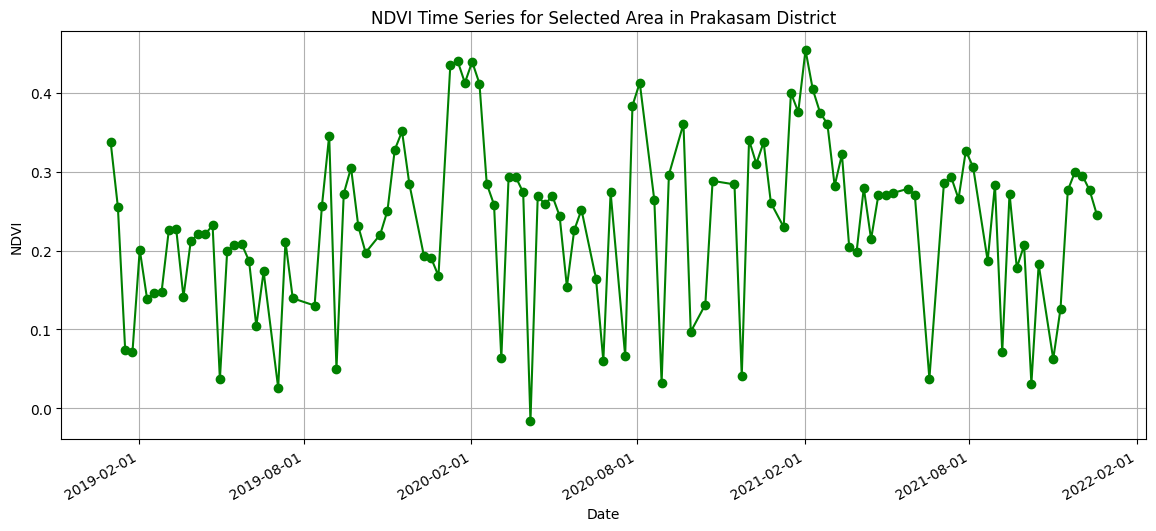

In [ ]:
plot_ndvi_time_series(dates, ndvi_values)

In [ ]:
ndvi_2019 = [value for value, date in zip(ndvi_values, dates) if date.year == 2019]
ndvi_2020 = [value for value, date in zip(ndvi_values, dates) if date.year == 2020]

In [ ]:
min_length = min(len(ndvi_2019), len(ndvi_2020))
ndvi_2019, ndvi_2020 = ndvi_2019[:min_length], ndvi_2020[:min_length]

In [ ]:
twdtw_distance = apply_twdtw(ndvi_2019, ndvi_2020)

In [ ]:
print(f"TWDTW Distance between 2019 and 2020 NDVI series: {twdtw_distance}")

TWDTW Distance between 2019 and 2020 NDVI series: 1.1186277629184511


## **VISUALIZATION**

In [ ]:
# Plotting function remains the same
def plot_ndvi_comparison(dates1, ndvi1, dates2, ndvi2, twdtw_distance):
    plt.figure(figsize=(14, 7))
    plt.plot(dates1, ndvi1, label='NDVI 2019', marker='o', linestyle='-', color='blue')
    plt.plot(dates2, ndvi2, label='NDVI 2020', marker='x', linestyle='-', color='orange')
    plt.text(min(dates1.min(), dates2.min()), max(ndvi1.max(), ndvi2.max()), f'TWDTW Distance: {twdtw_distance:.2f}', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.title('NDVI Time Series Comparison with TWDTW Distance')
    plt.xlabel('Date')
    plt.ylabel('Normalized NDVI')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
    plt.grid(True)
    plt.show()



In [ ]:
# Convert dates to a datetime format
dates_dt = pd.to_datetime(dates)

# Create a Pandas Series for dates
dates_series = pd.Series(dates_dt, index=dates_dt)

# Create a Pandas Series for NDVI values with the same datetime index
ndvi_series = pd.Series(ndvi_values, index=dates_dt)


In [ ]:
# Filter for 2019
dates_2019 = dates_series[dates_series.dt.year == 2019]
ndvi_2019 = ndvi_series[dates_series.dt.year == 2019]

# Filter for 2020
dates_2020 = dates_series[dates_series.dt.year == 2020]
ndvi_2020 = ndvi_series[dates_series.dt.year == 2020]


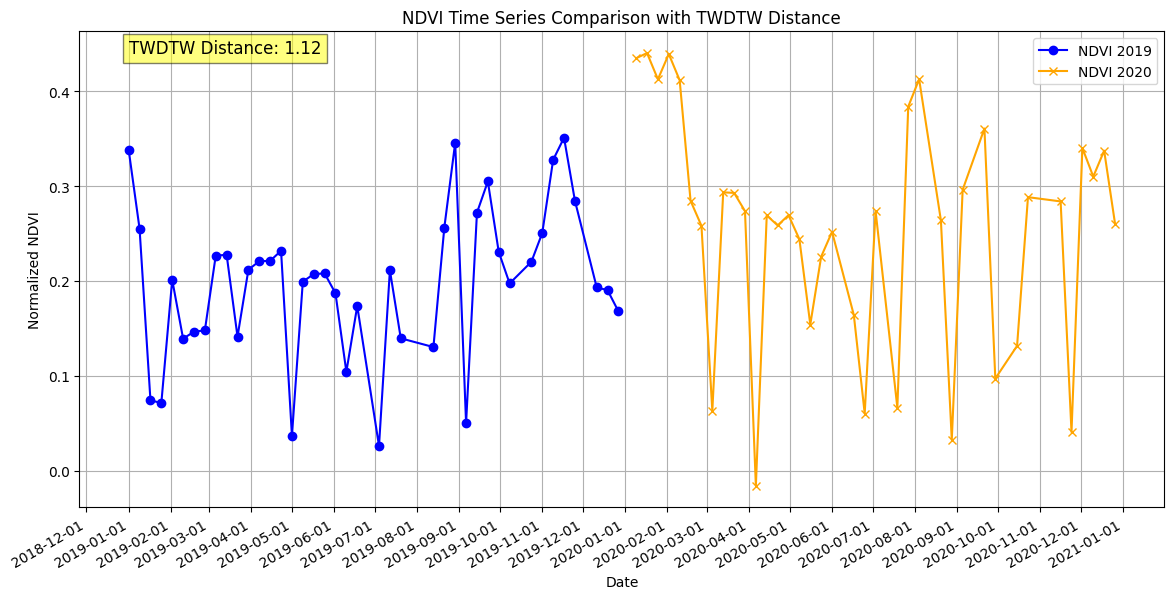

In [ ]:
plot_ndvi_comparison(dates_2019, ndvi_2019, dates_2020, ndvi_2020, twdtw_distance)

In [ ]:
# Synthetic reference NDVI values for demonstration (replace with your reference values)
reference_ndvi = np.sin(np.linspace(0, 3 * np.pi, len(ndvi_2019))) + np.random.normal(0, 0.1, len(ndvi_2019))

In [ ]:
def plot_twdtw_results(reference, actual, best_path, dates, title='TWDTW Alignment'):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Time steps for the x-axis
    time_steps = list(range(len(dates)))

    # Plot the reference and actual series
    ax.plot(time_steps, reference, label='Reference Series', color='blue', linestyle='--')
    ax.plot(time_steps, actual, label='Actual Series', color='green', linestyle='-')

    # Plot the warping path
    for (i, j) in best_path:
        ax.plot([i, j], [reference[i], actual[j]], color='red', alpha=0.5, linestyle=':')

    # Formatting the x-axis to show the correct dates
    ax.set_xticks(time_steps[::len(time_steps) // 10])  # Adjust the step for x-ticks as needed
    ax.set_xticklabels([dates[idx].strftime('%Y-%m-%d') for idx in time_steps[::len(time_steps) // 10]], rotation=45)

    ax.set_title(title)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Normalized NDVI')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [ ]:
def compute_twdtw_and_path(series1, series2, time_weight=0.5):
    series1 = np.array(series1) / np.max(series1)
    series2 = np.array(series2) / np.max(series2)

    time_component = np.linspace(0, time_weight, len(series1))
    series1_weighted = series1 + time_component
    series2_weighted = series2 + time_component

    # Compute DTW distance
    distance = dtw.distance(series1_weighted, series2_weighted)

    # Compute the warping path
    best_path = dtw.warping_path(series1_weighted, series2_weighted)

    return distance, best_path


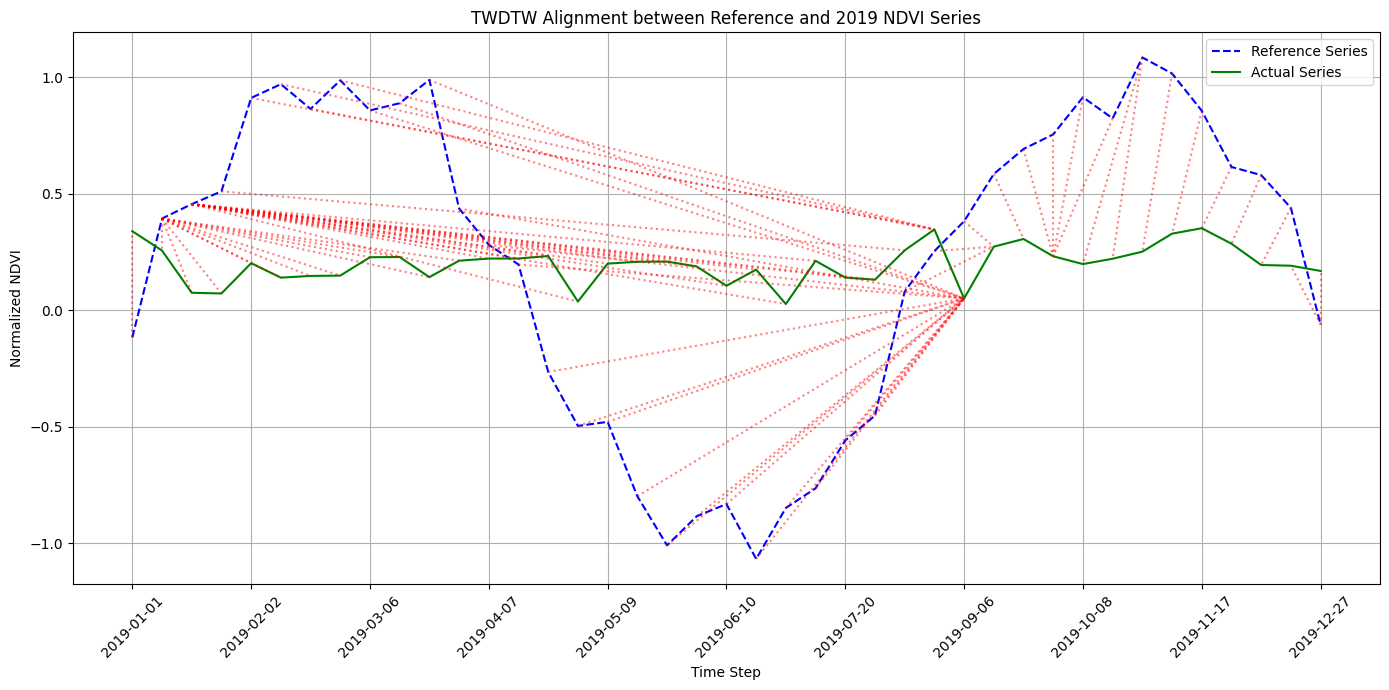

In [ ]:

# Compute TWDTW between the actual NDVI data for 2019 and the synthetic reference series
twdtw_distance, best_path = compute_twdtw_and_path(ndvi_2019.tolist(), reference_ndvi.tolist())

# Call the plotting function with the correct parameters
plot_twdtw_results(reference_ndvi, ndvi_2019, best_path, dates_2019, title='TWDTW Alignment between Reference and 2019 NDVI Series')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [ ]:
mse = mean_squared_error(ndvi_2019, reference_ndvi)
pearson_corr, _ = pearsonr(ndvi_2019, reference_ndvi)

In [ ]:
print(f"Mean Squared Error: {mse}")
print(f"Pearson Correlation Coefficient: {pearson_corr}")

Mean Squared Error: 0.42710788243846093
Pearson Correlation Coefficient: 0.2860960584048718
